# EEG data loading and pre-processing 

### Packages import

Packages are Python librairies, i.e. files that contain pre-written functions. We need to import the packages before using the functions that they include. For our purpose (MEG/EEG data analysis), most of the functions will be included in the MNE package, but we may have to use other packages too.

In [1]:
! pip install mne 
# I know we said this is bad practice, but let's do it anyways so we don't have to open any terminal ;)
! pip install scikit-learn --user

import mne # Here we import mne, the package that will contain most of the function that we will use today.
from mne.datasets.brainstorm import bst_raw # It is possible to import functions individually. This is helpful since it 
                                            # saves time, memory, and makes the calls to the function easier.
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs
%matplotlib notebook
# ^ This last line lets us use the interactive plots in Jupyter

### Loading the data

In [4]:
PARTICIPANTS = ['01', '04', '05', '06', '07', '09', '11', '12', '13', '14']

In [7]:
data_path = r'C:\Users\Dell\Jupyter\MNE_python'
raw = {}
#Load data for each of the 10 participants
for p in PARTICIPANTS:
    raw_fname = data_path + '\P' + p + '-raw.fif'
    raw[p] = mne.io.read_raw_fif(raw_fname, preload=True)

Opening raw data file C:\Users\Dell\Jupyter\MNE_python\P01-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.
Reading 0 ... 2478165  =      0.000 ...  4840.166 secs...
Opening raw data file C:\Users\Dell\Jupyter\MNE_python\P04-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2480032 =      0.000 ...  4843.812 secs
Ready.
Reading 0 ... 2480032  =      0.000 ...  4843.812 secs...
Opening raw data file C:\Users\Dell\Jupyter\MNE_python\P05-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2521101 =      0.000 ...  4924.025 secs
Ready.
Reading 0 ... 2521101  =      0.000 ...  4924.025 secs...
Opening raw data file C:\Users\Dell\Jupyter\MNE_python\P06-raw.fif...
Isotrak not found
    Read a total of 1 pr

In [ ]:

for p in PARTICIPANTS:

#Filtering
    raw[p].filter(0.5, 90., fir_design="firwin") # This method applies a bandpass filter to the data in "raw".
                                           # Here, we keep only frequencies between 0.5 and 150Hz, the rest will be attenuated.
    
    raw[p].notch_filter([60, 120], filter_length='auto',phase='zero', fir_design="firwin") # The notch filter will only
                                            # remove certain frequencies. Since in North America the power lines oscillates
                                            # at 60Hz, we will remove this frequency and it's first harmonic, 120Hz.
        
#ICA

ica = mne.preprocessing.ICA(n_components=20, random_state=0).fit(raw, decim=3)

eog_epochs = create_eog_epochs(raw, ch_name='EXG2')
eog_inds, eog_scores = ica.find_bads_eog(eog_epochs, ch_name='EXG2')
ica.plot_scores(eog_scores, eog_inds);
ica.plot_properties(eog_epochs, picks=eog_inds, psd_args={'fmax': 35.},
                    image_args={'sigma': 1.});

ica.exclude = eog_inds
ica.apply(raw) # Here we replace the old raw signal by the ICA recomposition

#Save datasets
filename = 'clean_dataset'
raw.save(data_path + '\\' + filename + '_raw.fif.gz', overwrite=True) # May be necessary to switch between '\\' and '/' depending on your OS

#Epoching
events = mne.find_events(raw)
events_modif = events.copy()

event_id = {'S1_p': 11, 'S1_i': 12,
            'S2_p': 21, 'S2_i': 22, 
            'S3_p': 31, 'S3_i': 32,
            'S4_p': 41, 'S4_i': 42,
            'S11_p': 111, 'S11_i': 112,
            'S12_p': 121, 'S12_i': 122, 
            'S13_p': 131, 'S13_i': 132,
            'S14_p': 141, 'S14_i': 142,
            'S21_p': 211, 'S21_i': 212,
            'S22_p': 221, 'S22_i': 222, 
            'S23_p': 231, 'S23_i': 232,
            'S24_p': 241, 'S24_i': 242}


#tmin, tmax = -0.5, 6.8 # Here we define the amount of time we want to keep before (tmin) and after (tmax) the event.
                       # Thus, we will split our signal into 0.7s chunks.
    
#baseline = (-0.5, -0.1) # When epoching, we often want to use some kind of baseline correction. Here, we define that our baseline
                       # starts at the beginning of the epoch and goes until the stimulus occurence (t=0)
    
#reject = {'eeg': 40e-6} # The Epochs() function allows to automatically reject events in which one or more channels exceeds a
                        # threshold value. We can set different values for different types of channels (mag, grad, eeg etc...).
                        # This is useful because even a meticulous pre-processing may leave some noisy segments in the data, and
                        # this method only rejects the contaminated trials while keeping the others intact.
            
#picks = mne.pick_types(raw.info, eeg=True)
                       #eeg=False, eog=False) # We choose to analyse only the magnetometers ('mag')

#epochs = mne.Epochs(raw, events=events_modif, event_id=event_id, tmin=tmin,
#                    tmax=tmax, baseline=baseline, reject=None)

### MNE data objects

The MNE data objects contains the data + some information (sampling frequency, number of channels etc...). It is very convenient since most MNE functions will be applied directly on this object, and you can access everything in the same place. 

In [14]:
raw['01'].info # For example, you can use the method "info" to look at the informations about your data
#raw['01'].info.get('ch_names')
#raw.check_trial_events()

<Info | 18 non-empty fields
    bads : list | P8, P10, T8
    ch_names : list | Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, ...
    chs : list | 69 items (EEG: 64, EOG: 4, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dig : Digitization | 0 items
    events : list | 0 items
    file_id : dict | 4 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 104.0 Hz
    meas_date : tuple | 2015-01-28 17:39:57 GMT
    meas_id : dict | 4 items
    nchan : int | 69
    proc_history : list | 0 items
    projs : list | Average EEG reference: off
    sfreq : float | 512.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dev_head_t : NoneType
    experimenter : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    proj_id : NoneType
    proj_name : NoneTy

In [5]:
raw.info.get('sfreq') # Or you can access each field separately by using get() (here, we ask for the sampling frequency)

512.0

<IPython.core.display.Javascript object>


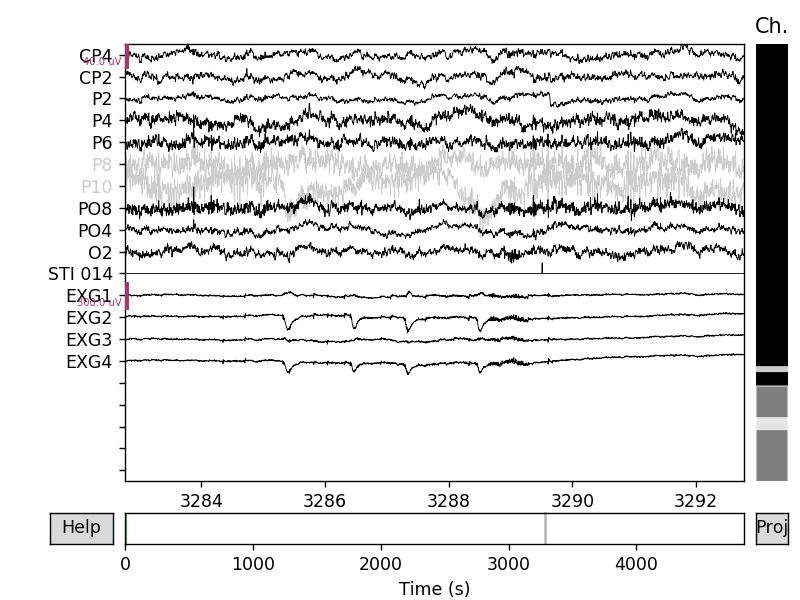

In [8]:
raw.plot(); # You can also plot the timeseries of your data and scroll to explore them visually.
           # The plot method can take many arguments to help you plot the data the way you want.
           # Any transformation commanded by these arguments (e.g. filtering) will ONLY apply to the plotted data, 
           # the content of "raw" will be left untouched.

<IPython.core.display.Javascript object>


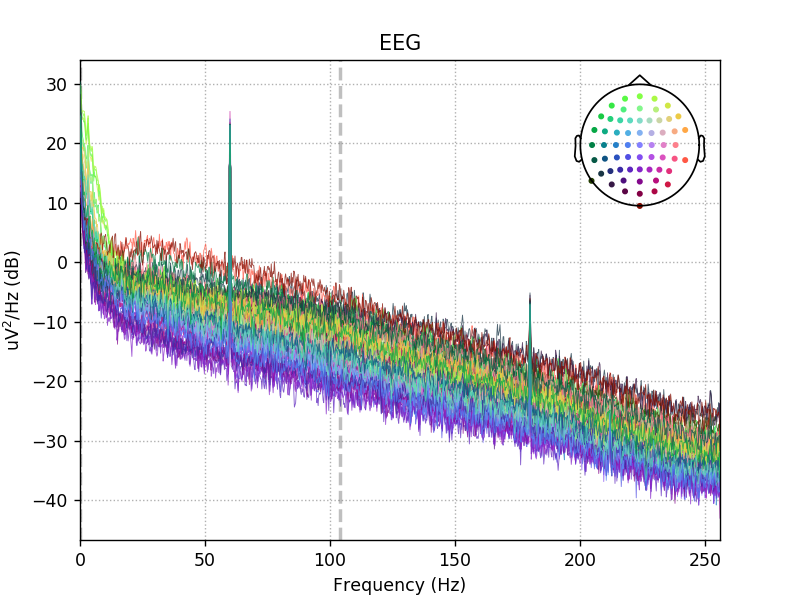

Effective window size : 4.000 (s)


In [5]:
# Let's have a quick look at the spectrum of our data
raw.plot_psd(tmax=60., average=False);

### Filtering

Before doing anything with our data, we usually want to filter them in order to remove specific frequency bands.
1. We want to remove frequencies that are either too low or too high to be meaningful to us
    -> Band-pass filter
2. We want to remove the line noise (i.e. noise generated by the alternative current used to power electric devices)
    -> Notch filter

In [4]:


raw.filter(0.5, 90., fir_design="firwin") # This method applies a bandpass filter to the data in "raw".
                                           # Here, we keep only frequencies between 0.5 and 150Hz, the rest will be attenuated.
    
raw.notch_filter([60, 120], filter_length='auto',phase='zero', fir_design="firwin") # The notch filter will only
                                            # remove certain frequencies. Since in North America the power lines oscillates
                                            # at 60Hz, we will remove this frequency and it's first harmonic, 120Hz.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 22.50 Hz (-6 dB cutoff frequency: 101.25 Hz)
- Filter length: 3379 samples (6.600 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3379 samples (6.600 sec)



<Raw  |  P01-raw.fif, n_channels x n_times : 69 x 2478166 (4840.2 sec), ~1.27 GB, data loaded>

<IPython.core.display.Javascript object>


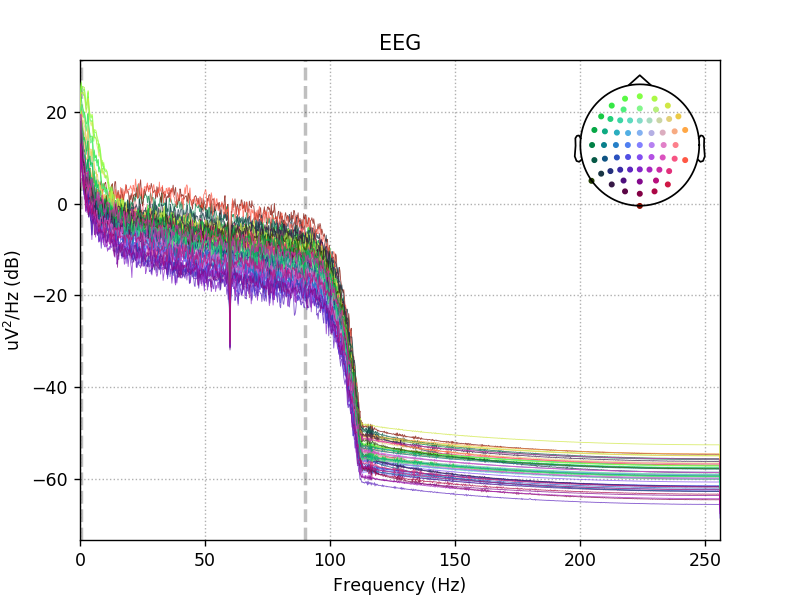

Effective window size : 4.000 (s)


In [10]:
# Plot a new spectrum to see how the signal was modified
raw.plot_psd(tmax=60., average=False);

### ICA decomposition

The next classical step to MEG/EEG pre-processing is to run an Independent Component Analysis (ICA) in order to detect and remove occular and cardiac artifacts from our signal.

In [15]:
ica = mne.preprocessing.ICA(n_components=20, random_state=0).fit(raw, decim=3) # We compute an ICA object from the data.
# The n_components argument defines the number of components that we wish to obtain.
# It is also possible to state that 0<n_components<1, in which case it will define the proportion of variance that 
# we want to be explained by the N components. 

Fitting ICA to data using 61 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 20 components
Fitting ICA took 35.1s.


<IPython.core.display.Javascript object>


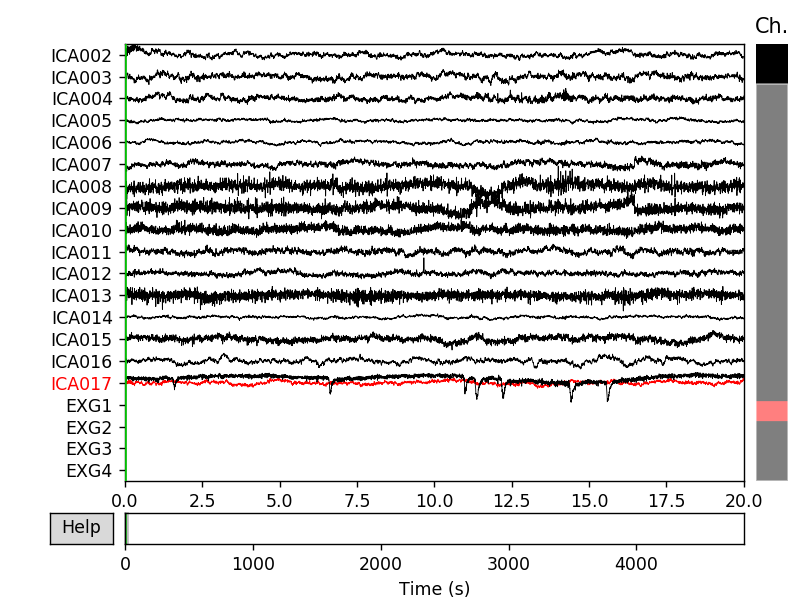

In [6]:
ica.plot_sources(raw); # We can plot our components and explore them visually to get 
                      # an idea of which artifact was captured by which component. What do we see ?

Looking at the above plot, we can guess that the last component (ICA019) captures cardiac activity. ICA001 looks like it has captured ocular blinks.
However, this is kind of arbitrary. Let's confirm our guesses with an automatic method. Hopefully, this dataset has an ECG and EOG channels that will help us find the artifactual components. If it is not the case, this method will still work although it may make more mistakes. 

In [8]:
# First, we will start by looking for the component(s) that captured cardiac activity.

ecg_epochs = create_ecg_epochs(raw, ch_name='EEG057') # This function will detect cardiac events (heartbeats) on the ECG signal
                                                      # and store their timestamps in "ecg_epochs".

ecg_inds, ecg_scores = ica.find_bads_ecg(ecg_epochs, ch_name='EEG057') # Now, this function correlates, at the timestamps
                                                      # specified by "ecg_epochs", the activity on EEG057 (our ECG channel) with
                                                      # each ICA component. The component with the greatest correlation is most
                                                      # likely the one we are looking for !

ica.plot_scores(ecg_scores, ecg_inds); # Let's plot the correlations scores for each ICA components. 
                                      # "ecg_inds" contains the indices of components identified as cardiac activity.

ica.plot_properties(ecg_epochs, picks=ecg_inds, psd_args={'fmax': 35.}, # Plot the topography and variance of the components in
                    image_args={'sigma': 1.});

ValueError: EEG057 not in channel list (['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'EXG1', 'EXG2', 'EXG3', 'EXG4', 'STI 014'])

Using channel EXG2 as EOG channel
EOG channel index for this subject is: [65]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 8192 samples (16.000 sec)

Now detecting blinks and generating corresponding events
Number of EOG events detected : 1579
1579 matching events found
No baseline correction applied
Not setting metadata
Loading data for 1579 events and 513 original time points ...
0 bad epochs dropped
Using channel EXG2 as EOG channel


<IPython.core.display.Javascript object>


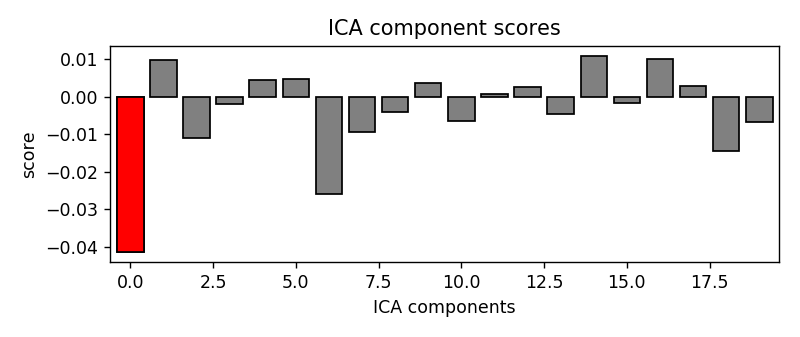

<IPython.core.display.Javascript object>


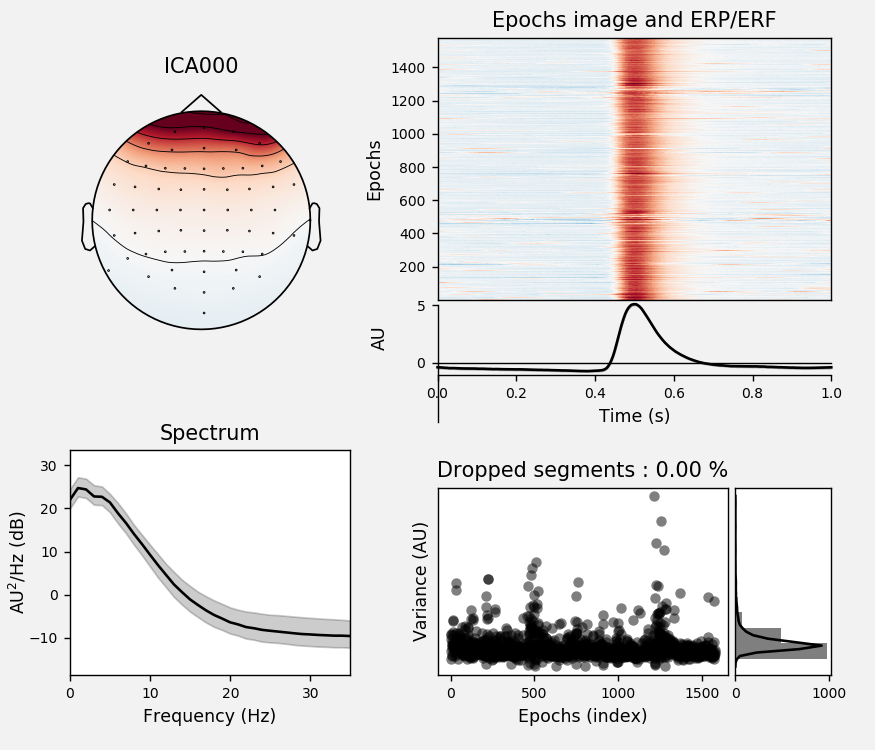

    Using multitaper spectrum estimation with 7 DPSS windows
1579 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


In [16]:
# Now, let's do the same for ocular blinks. Note that two things have changed :
# - The functions used to detect artifacts are now called "eog" instead of "ecg"
# - The channel to which we correlate our components is now EEG058, the EOG channel
eog_epochs = create_eog_epochs(raw, ch_name='EXG2')
eog_inds, eog_scores = ica.find_bads_eog(eog_epochs, ch_name='EXG2')
ica.plot_scores(eog_scores, eog_inds);
ica.plot_properties(eog_epochs, picks=eog_inds, psd_args={'fmax': 35.},
                    image_args={'sigma': 1.});

Transforming to ICA space (20 components)
Zeroing out 1 ICA components


<IPython.core.display.Javascript object>


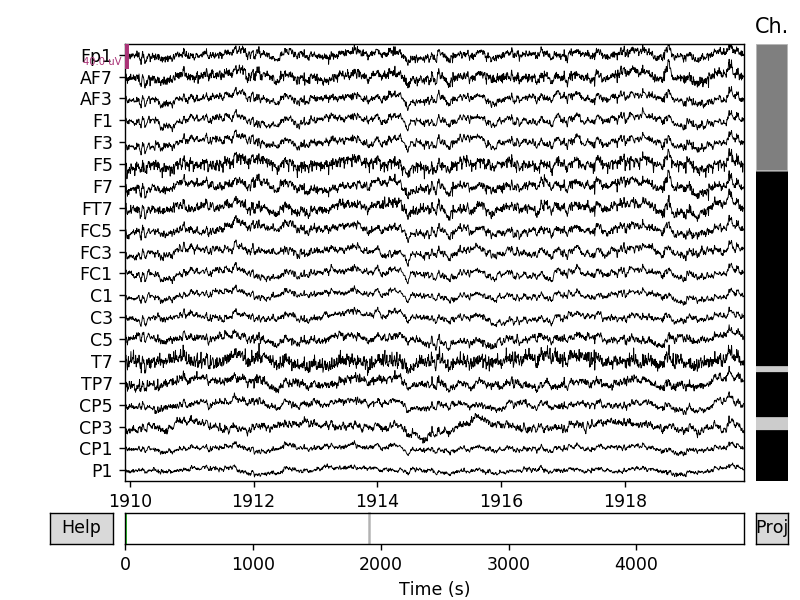

In [17]:
# Finally, we can recompose our signal while excluding the artifactual components : 

#ica.exclude = [1, 19] # We can also index the components individually, useful if we don't agree with the automatic detection

#ica.exclude = ecg_inds # Exclude cardiac (ECG) or blinks (EOG) components 
#ica.apply(raw) # Here we replace the old raw signal by the ICA recomposition

ica.exclude = eog_inds
ica.apply(raw) # Here we replace the old raw signal by the ICA recomposition


raw.plot(); # Plot the clean signal.

### Saving datasets

In [34]:
# Now that our pre-processing is done, it is time to save our clean dataset

filename = 'clean_dataset'
raw.save(data_path + '\\' + filename + '_raw.fif.gz', overwrite=True) # May be necessary to switch between '\\' and '/' depending on your OS

Writing C:\Users\Dell\Jupyter\MNE_python\clean_dataset_raw.fif.gz
Closing C:\Users\Dell\Jupyter\MNE_python\clean_dataset_raw.fif.gz [done]


In [39]:
events = mne.find_events(raw)
events_modif = events.copy()

event_id = {'S1_p': 11, 'S1_i': 12,
            'S2_p': 21, 'S2_i': 22, 
            'S3_p': 31, 'S3_i': 32,
            'S4_p': 41, 'S4_i': 42,
            'S11_p': 111, 'S11_i': 112,
            'S12_p': 121, 'S12_i': 122, 
            'S13_p': 131, 'S13_i': 132,
            'S14_p': 141, 'S14_i': 142,
            'S21_p': 211, 'S21_i': 212,
            'S22_p': 221, 'S22_i': 222, 
            'S23_p': 231, 'S23_i': 232,
            'S24_p': 241, 'S24_i': 242}

540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2001]


In [26]:
24*5

120

In [33]:
# Epoching for each song and each condition

events = mne.find_events(raw)
events_modif = events.copy()

for e in events_modif:
    if int(str(e[2])) == 1111:
        e[2] = 0
for e in events_modif:
    if int(str(e[2])) == 2001:
        e[2] = 0
        
for e in events_modif:
    if int(str(e[2])[-1]) == 1:
        e[2] = 1
    elif int(str(e[2])[-1]) == 2:
        e[2] = 2
    elif int(str(e[2])[-1]) == 3:
        e[2] = 3
events_modif
        #int(str(events[0][2])[-1])
event_id = {'Percept': 1, 'Imagine_cued': 2}

540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2001]


<ipython-input-40-d24259256573>:1: RuntimeWarning: More events than colors available. You should pass a list of unique colors.
  mne.viz.plot_events(events, raw.info['sfreq'], raw.first_samp);


<IPython.core.display.Javascript object>


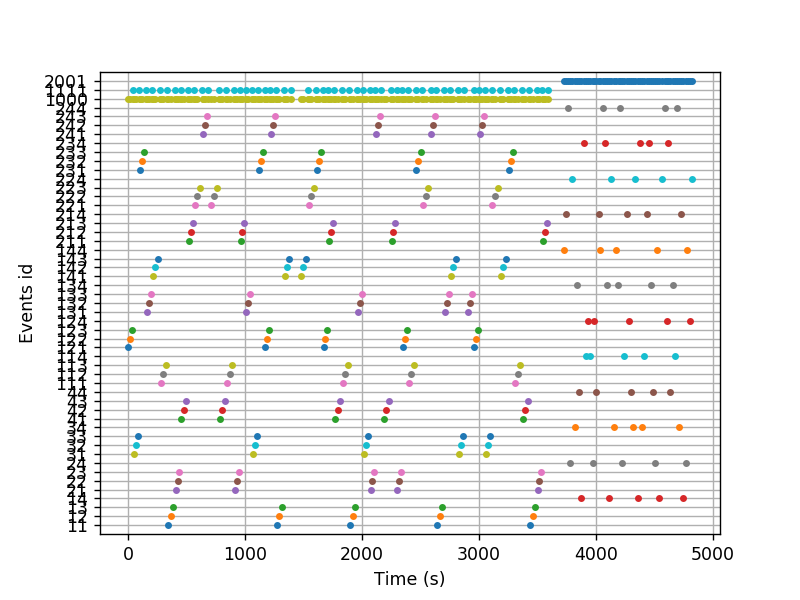

In [40]:
mne.viz.plot_events(events, raw.info['sfreq'], raw.first_samp);
                    #event_id=event_id);

In [40]:
tmin, tmax = -0.5, 6.8 # Here we define the amount of time we want to keep before (tmin) and after (tmax) the event.
                       # Thus, we will split our signal into 0.7s chunks.
    
baseline = (-0.5, -0.1) # When epoching, we often want to use some kind of baseline correction. Here, we define that our baseline
                       # starts at the beginning of the epoch and goes until the stimulus occurence (t=0)
    
reject = {'eeg': 40e-6} # The Epochs() function allows to automatically reject events in which one or more channels exceeds a
                        # threshold value. We can set different values for different types of channels (mag, grad, eeg etc...).
                        # This is useful because even a meticulous pre-processing may leave some noisy segments in the data, and
                        # this method only rejects the contaminated trials while keeping the others intact.
            
picks = mne.pick_types(raw.info, eeg=True)
                       #eeg=False, eog=False) # We choose to analyse only the magnetometers ('mag')

epochs = mne.Epochs(raw, events=events_modif, event_id=event_id, tmin=tmin,
                    tmax=tmax, baseline=baseline, reject=None)
                    #, picks=picks) # This function splits the signal into epochs that
                                                                             # can be accessed separately by calling epochs[condition]

#epochs.drop_bad() # Here, we drop the epochs that were marked as bad using the "reject" parameter. 
                  # The dropped epochs will not be used for further analysis.

120 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
1 projection items activated


In [86]:
evoked = epochs['Percept'].average()

Loading data for 60 events and 3739 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


<IPython.core.display.Javascript object>


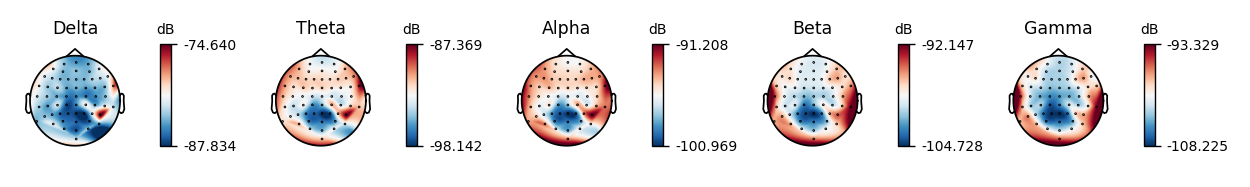

Loading data for 60 events and 3739 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


<IPython.core.display.Javascript object>


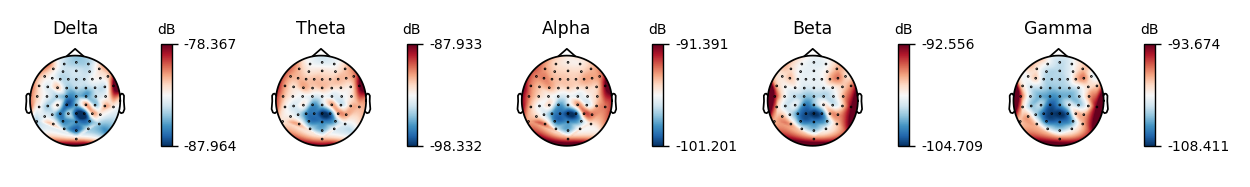

In [17]:
epochs['Percept'].plot_psd_topomap(); # You can also plot the topographies of frequency bands.
epochs['Imagine_cued'].plot_psd_topomap();  # Let's compare both conditions !

In [41]:
import numpy


def hurst(X):
    """ Compute the Hurst exponent of X. If the output H=0.5,the behavior
    of the time-series is similar to random walk. If H<0.5, the time-series
    cover less "distance" than a random walk, vice verse.
    Parameters
    ----------
    X
        list
        a time series
    Returns
    -------
    H
        float
        Hurst exponent
    Notes
    --------
    Author of this function is Xin Liu
    Examples
    --------
    >>> import pyeeg
    >>> from numpy.random import randn
    >>> a = randn(4096)
    >>> pyeeg.hurst(a)
    0.5057444
    """
    X = numpy.array(X)
    N = X.size
    T = numpy.arange(1, N + 1)
    Y = numpy.cumsum(X)
    Ave_T = Y / T

    S_T = numpy.zeros(N)
    R_T = numpy.zeros(N)

    for i in range(N):
        S_T[i] = numpy.std(X[:i + 1])
        X_T = Y - T * Ave_T[i]
        R_T[i] = numpy.ptp(X_T[:i + 1])

    R_S = R_T / S_T
    R_S = numpy.log(R_S)[1:]
    n = numpy.log(T)[1:]
    A = numpy.column_stack((n, numpy.ones(n.size)))
    [m, c] = numpy.linalg.lstsq(A, R_S)[0]
    H = m
    return H

In [50]:
S1_p = epochs['S1_p'].get_data()
S1_i = epochs['S1_i'].get_data()

hurst_sensors_S1_p = []
for 
    for s in range(64):
        hurst_sensors_S1_p.append(hurst(S1_i[:, s, :]))
    

Loading data for 5 events and 3739 original time points ...
0 bad epochs dropped
Loading data for 5 events and 3739 original time points ...
0 bad epochs dropped


C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [52]:
hurst_sensors_s1_i = hurst_sensors_S1_p
hurst_sensors_s1_i

[0.7334130628192319,
 0.6301888109555179,
 0.8703184931386634,
 0.8345769296501379,
 0.7606237505264214,
 0.8808535758715642,
 0.7758169883599904,
 0.9391219746543805,
 0.9743382633358887,
 0.7748317121712903,
 0.8339996996697836,
 0.8782973362939848,
 0.8394065490385888,
 1.119408304876484,
 0.586242529719156,
 0.8049338961808876,
 0.7751145780608409,
 0.9146042796242828,
 0.7487448709462984,
 0.8521133510578375,
 1.0090192250560428,
 0.9407486463604261,
 0.9138764705004044,
 0.7390168033968962,
 0.9950976880126169,
 0.9842715144054148,
 1.0883281607693143,
 1.0711670448498747,
 1.0073830764190745,
 1.2411747776410393,
 0.95559783009241,
 0.8486008002838581,
 0.9145653920056488,
 0.8839488196981748,
 0.8647770928325934,
 1.023576799165219,
 0.8628996288855247,
 0.867448719753753,
 0.9104088528870006,
 0.8938239401038134,
 0.7258200197713198,
 0.9975166394079563,
 1.1336019295798585,
 0.8116601273948061,
 0.8411644790956003,
 0.9314935254606762,
 0.8673800914151898,
 0.8107516688918391

In [ ]:
data_percept = epochs['Percept'].get_data()
data_imagined = epochs['Imagine_cued'].get_data()
hurst_sensors_p = []
hurst_sensors_i = []
#first sensor, all events  (event, sensor, timestamp)
for s in range(64):
    hurst_sensors_p.append(hurst(data_percept[:, s, :]))
    hurst_sensors_i.append(hurst(data_imagined[:, s, :]))




Loading data for 60 events and 3739 original time points ...
0 bad epochs dropped
Loading data for 60 events and 3739 original time points ...
0 bad epochs dropped


C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [15]:
raw.info['ch_names']

['Fp1',
 'AF7',
 'AF3',
 'F1',
 'F3',
 'F5',
 'F7',
 'FT7',
 'FC5',
 'FC3',
 'FC1',
 'C1',
 'C3',
 'C5',
 'T7',
 'TP7',
 'CP5',
 'CP3',
 'CP1',
 'P1',
 'P3',
 'P5',
 'P7',
 'P9',
 'PO7',
 'PO3',
 'O1',
 'Iz',
 'Oz',
 'POz',
 'Pz',
 'CPz',
 'Fpz',
 'Fp2',
 'AF8',
 'AF4',
 'AFz',
 'Fz',
 'F2',
 'F4',
 'F6',
 'F8',
 'FT8',
 'FC6',
 'FC4',
 'FC2',
 'FCz',
 'Cz',
 'C2',
 'C4',
 'C6',
 'T8',
 'TP8',
 'CP6',
 'CP4',
 'CP2',
 'P2',
 'P4',
 'P6',
 'P8',
 'P10',
 'PO8',
 'PO4',
 'O2',
 'EXG1',
 'EXG2',
 'EXG3',
 'EXG4',
 'STI 014']